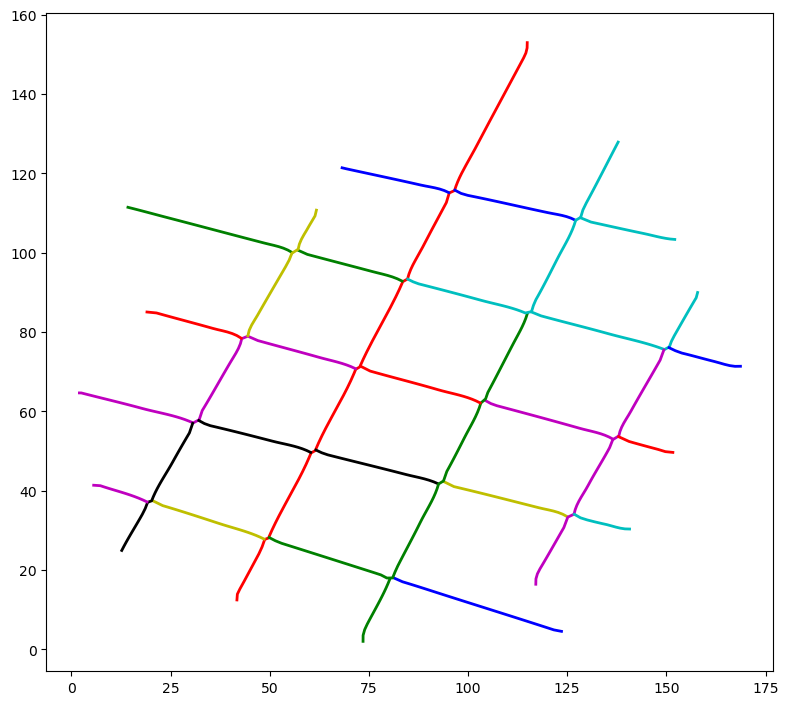

['Straight Line', 'Straight Line', 'Straight Line', 'Other', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Other', 'Straight Line', 'Other', 'Other', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line', 'Straight Line']
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


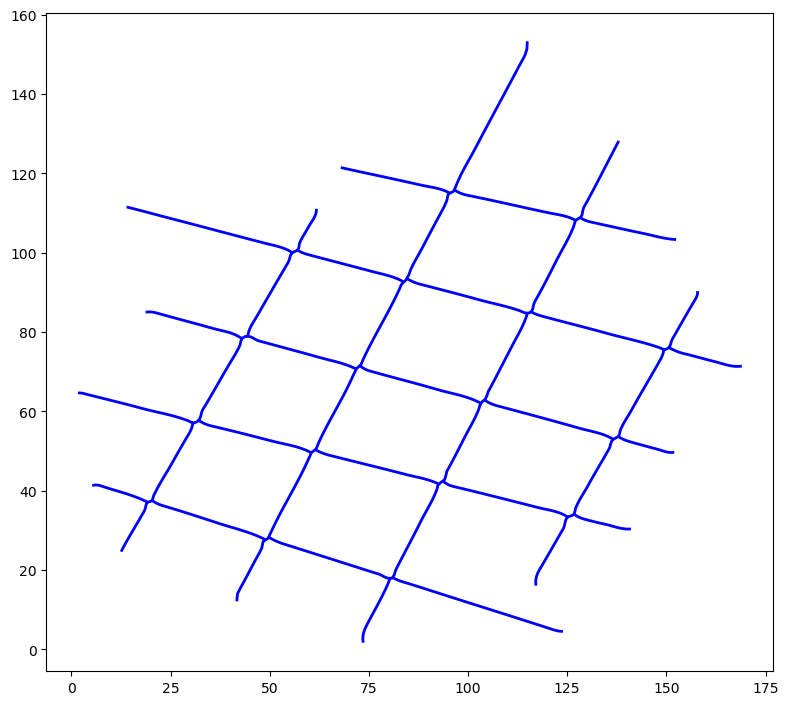

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from sklearn.linear_model import LinearRegression
import svgwrite

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def is_straight_line(XY):
    model = LinearRegression()
    X = XY[:, 0].reshape(-1, 1)
    y = XY[:, 1]
    model.fit(X, y)
    score = model.score(X, y)
    return score > 0.80

def is_circle_or_ellipse(XY):
    center = np.mean(XY, axis=0)
    distances = np.linalg.norm(XY - center, axis=1)
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    return std_dist / mean_dist < 0.1

def is_polygon(XY, num_sides):
    hull = ConvexHull(XY)
    return len(hull.vertices) == num_sides

def regularize_curves(paths_XYs):
    regularized_paths = []
    for XYs in paths_XYs:
        for XY in XYs:
            if is_straight_line(XY):
                regularized_paths.append('Straight Line')
            elif is_circle_or_ellipse(XY):
                regularized_paths.append('Circle/Ellipse')
            elif is_polygon(XY, 3):
                regularized_paths.append('Triangle')
            elif is_polygon(XY, 4):
                regularized_paths.append('Rectangle')
            else:
                regularized_paths.append('Other')
    return regularized_paths

def find_symmetry(XY):
    center = np.mean(XY, axis=0)
    for angle in np.linspace(0, np.pi, 180):
        rot_matrix = np.array([
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)]
        ])
        rotated = (XY - center) @ rot_matrix.T + center
        if np.allclose(XY, rotated, atol=0.1):
            return angle
    return None

def explore_symmetry(paths_XYs):
    symmetries = []
    for XYs in paths_XYs:
        for XY in XYs:
            angle = find_symmetry(XY)
            if angle is not None:
                symmetries.append(angle)
    return symmetries

def complete_curve(XY):
    tck, u = splprep([XY[:, 0], XY[:, 1]], s=0)
    new_points = splev(np.linspace(0, 1, 100), tck)
    return np.vstack(new_points).T

def complete_incomplete_curves(paths_XYs):
    completed_paths = []
    for XYs in paths_XYs:
        for XY in XYs:
            completed_path = complete_curve(XY)
            completed_paths.append(completed_path)
    return completed_paths

def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()
    colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    for i, path in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in path:
            path_data = [("M", (XY[0, 0], XY[0, 1]))]
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
            group.add(dwg.path(d=path_data, fill='none', stroke=c, stroke_width=2))
    dwg.add(group)
    dwg.save()

# Example usage
csv_path = '/Users/sanatwalia/Downloads/problems/frag2.csv'
paths_XYs = read_csv(csv_path)
plot(paths_XYs)

regularized_paths = regularize_curves(paths_XYs)
print(regularized_paths)

symmetries = explore_symmetry(paths_XYs)
print(symmetries)

completed_paths = complete_incomplete_curves(paths_XYs)
plot([completed_paths])

svg_path = 'output.svg'
polylines2svg(paths_XYs, svg_path)
